In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import joblib
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cấu hình đường dẫn đầu vào/đầu ra
model_name = "RandomForest"
input_folder = 'folder_standardized'
output_folder = 'models_and_results'
os.makedirs(output_folder, exist_ok=True)

print("--- KHỞI TẠO RANDOM FOREST ---")

--- KHỞI TẠO RANDOM FOREST ---


In [3]:
def load_data():
    """
    Đọc dữ liệu đã xử lý từ folder_standardized (kết quả của processing.ipynb).
    
    Returns:
        tuple: (X_train, y_train, X_test, y_test) - Bộ dữ liệu huấn luyện và kiểm tra
        
    Raises:
        FileNotFoundError: Nếu không tìm thấy dữ liệu đã xử lý
    """
    print("\n1. LOAD DATA")
    try:
        X_train = pd.read_csv(os.path.join(input_folder, 'X_train.csv'))
        y_train = pd.read_csv(os.path.join(input_folder, 'y_train.csv')).values.ravel()
        X_test = pd.read_csv(os.path.join(input_folder, 'X_test.csv'))
        y_test = pd.read_csv(os.path.join(input_folder, 'y_test.csv')).values.ravel()
        
        print(f"   - Đọc dữ liệu thành công")
        print(f"   - X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"   - X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
        return X_train, y_train, X_test, y_test
    except FileNotFoundError:
        print("   ✗ Lỗi: Không tìm thấy dữ liệu. Hãy chạy processing.ipynb trước!")
        exit()

X_train, y_train, X_test, y_test = load_data()


1. LOAD DATA
   - Đọc dữ liệu thành công
   - X_train shape: (5616, 34), y_train shape: (5616,)
   - X_test shape: (1405, 34), y_test shape: (1405,)


In [4]:
def train_model():
    """
    Huấn luyện mô hình Random Forest với tối ưu hóa tham số.
    
    Quy trình:
    1. Xây dựng Pipeline gồm SMOTE (cân bằng dữ liệu) + Random Forest
    2. Sử dụng RandomizedSearchCV (vì không gian tham số quá lớn)
    3. Thử 15 tổ hợp tham số ngẫu nhiên (nhanh hơn GridSearchCV)
    4. Tối ưu hóa theo điểm F1
    5. Tìm ngưỡng phân loại tối ưu
    
    Returns:
        tuple: (best_model, best_threshold, y_prob) - Model, ngưỡng tối ưu, xác suất dự đoán
    """
    print(f"\n2. TRAIN MODEL: {model_name}")
    
    # Pipeline: SMOTE (xử lý class imbalance) -> Random Forest
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', RandomForestClassifier(random_state=42))
    ])
    
    # Lưới tham số cần tối ưu
    param_grid = {
        'model__n_estimators': [100, 200, 300],                           # Số cây trong forest
        'model__max_depth': [5, 8, 10],                                   # Độ sâu cây (None = vô hạn)
        'model__min_samples_split': [10, 15, 20],                         # Số mẫu tối thiểu chia nút
        'model__min_samples_leaf': [5, 10],                               # Số mẫu tối thiểu ở lá
        'model__max_features': ['sqrt', 0.5],                             # Giới hạn số features mỗi lần split
        'model__class_weight': ['balanced', 'balanced_subsample']         # Cân bằng trọng số class
    }
    
    # RandomizedSearchCV: Thử n_iter tổ hợp ngẫu nhiên (nhanh hơn GridSearchCV cho RF)
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=15,        # Thử 15 tổ hợp ngẫu nhiên (đủ khám phá không gian tham số)
        scoring='f1',     # Tối ưu hóa theo F1-score
        cv=3,             # 3-fold cross-validation
        verbose=1,
        random_state=42,
        n_jobs=-1         # Sử dụng tất cả CPU cores
    )
    
    print("   - Đang tìm tham số tối ưu (RandomizedSearchCV)...")
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    print(f"   - Tham số tốt nhất: {search.best_params_}")
    
    # Tìm ngưỡng phân loại tối ưu
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import precision_recall_curve
    
    print("   - Đang tìm ngưỡng tối ưu dựa trên Cross-Validation của tập Train...")
    # Lấy xác suất của lớp 1 (Churn) trên tập train
    y_train_prob_cv = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    
    # Tính toán precision, recall dựa trên y_train và xác suất vừa tạo
    precision, recall, thresholds = precision_recall_curve(y_train, y_train_prob_cv)
    
    # Tính F1 score cho mọi ngưỡng
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Lấy ngưỡng có F1 cao nhất (Lưu ý: bỏ qua giá trị nan nếu có)
    f1_scores = np.nan_to_num(f1_scores) 
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    print(f"   - Ngưỡng phân loại tối ưu (tìm trên Train): {best_threshold:.4f}")
    
    # 3. Tạo y_prob cho tập Test để trả về (Dùng cho bước Evaluate sau này)
    y_prob_test = best_model.predict_proba(X_test)[:, 1]
    
    return best_model, best_threshold, y_prob_test

best_model, best_threshold, y_prob = train_model()


2. TRAIN MODEL: RandomForest
   - Đang tìm tham số tối ưu (RandomizedSearchCV)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
   - Tham số tốt nhất: {'model__n_estimators': 100, 'model__min_samples_split': 20, 'model__min_samples_leaf': 10, 'model__max_features': 'sqrt', 'model__max_depth': 8, 'model__class_weight': 'balanced_subsample'}
   - Đang tìm ngưỡng tối ưu dựa trên Cross-Validation của tập Train...
   - Ngưỡng phân loại tối ưu (tìm trên Train): 0.5375


In [5]:
def evaluate_model(best_threshold, y_prob):
    """
    Đánh giá hiệu suất mô hình trên tập Test với ngưỡng tối ưu.
    
    Args:
        best_threshold (float): Ngưỡng phân loại tối ưu (0-1)
        y_prob (ndarray): Xác suất dự đoán class=1 từ mô hình
    
    Returns:
        ndarray: Dự đoán nhị phân (0 hoặc 1) sau áp dụng ngưỡng
    """
    print("\n3. EVALUATE MODEL")
    
    # Áp dụng ngưỡng phân loại tối ưu
    y_pred = (y_prob >= best_threshold).astype(int)
    
    # Hiển thị báo cáo phân loại chi tiết
    print(f"   - Dự đoán với ngưỡng {best_threshold:.4f}:")
    print("\n" + classification_report(y_test, y_pred, 
                                      target_names=['No Churn', 'Yes Churn']))
    
    return y_pred

y_pred = evaluate_model(best_threshold, y_prob)


3. EVALUATE MODEL
   - Dự đoán với ngưỡng 0.5375:

              precision    recall  f1-score   support

    No Churn       0.89      0.78      0.83      1053
   Yes Churn       0.53      0.72      0.61       352

    accuracy                           0.77      1405
   macro avg       0.71      0.75      0.72      1405
weighted avg       0.80      0.77      0.78      1405




ĐÁNH GIÁ CHI TIẾT MÔ HÌNH: RandomForest

Chỉ số          Train        Test         Chênh lệch     
------------------------------------------------------------
Accuracy        0.8052       0.7673       0.0379         
Precision       0.6079       0.5261       0.0818         
Recall          0.7694       0.7159       0.0535         
F1-Score        0.6792       0.6065       0.0727         
ROC-AUC         0.8797       0.8410       0.0387         

PHÂN TÍCH MÔ HÌNH:
⚠ Mô hình có độ tổng quát hóa KHÁ
  → Chênh lệch giữa Train và Test ở mức trung bình (5-10%)


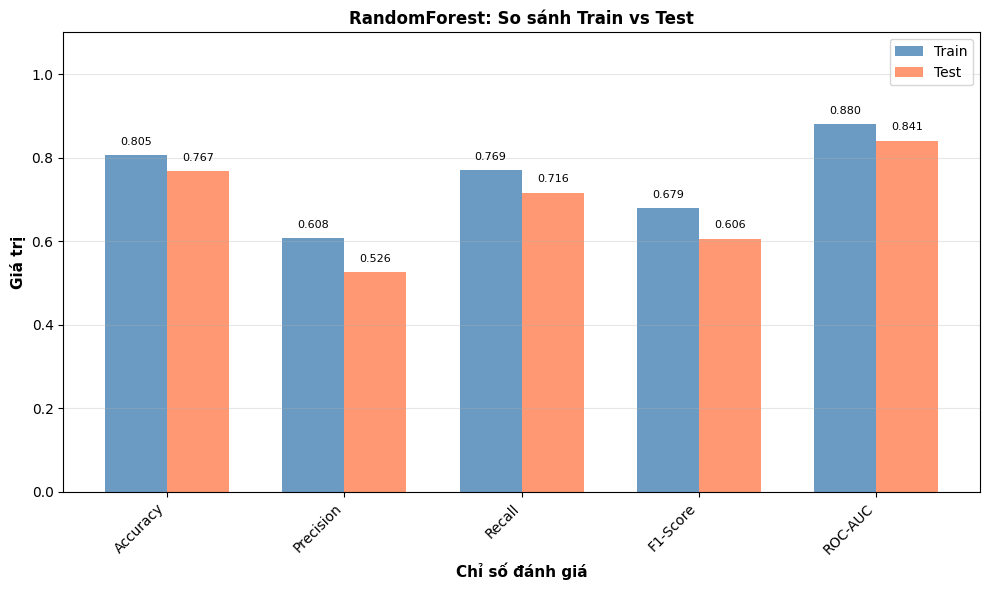


✓ Đã lưu biểu đồ đánh giá tại: models_and_results\RandomForest_comprehensive_evaluation.png



In [6]:
def comprehensive_model_evaluation(best_model, best_threshold, X_train, y_train, X_test, y_test, model_name):
    """
    Đánh giá toàn diện mô hình trên cả tập Train và Test, so sánh hiệu suất.
    
    Args:
        best_model: Mô hình đã được huấn luyện
        best_threshold: Ngưỡng phân loại tối ưu
        X_train, y_train: Dữ liệu training
        X_test, y_test: Dữ liệu testing
        model_name: Tên mô hình
    """
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print(f"\n{'='*60}")
    print(f"ĐÁNH GIÁ CHI TIẾT MÔ HÌNH: {model_name}")
    print(f"{'='*60}\n")
    
    # Dự đoán cho cả 2 tập
    y_train_prob = best_model.predict_proba(X_train)[:, 1]
    y_train_pred = (y_train_prob >= best_threshold).astype(int)
    
    y_test_prob = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_prob >= best_threshold).astype(int)
    
    # Tính các chỉ số cho Train
    train_metrics = {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred),
        'Recall': recall_score(y_train, y_train_pred),
        'F1-Score': f1_score(y_train, y_train_pred),
        'ROC-AUC': roc_auc_score(y_train, y_train_prob)
    }
    
    # Tính các chỉ số cho Test
    test_metrics = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1-Score': f1_score(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_prob)
    }
    
    # In bảng so sánh
    print(f"{'Chỉ số':<15} {'Train':<12} {'Test':<12} {'Chênh lệch':<15}")
    print("-" * 60)
    for metric in train_metrics.keys():
        train_val = train_metrics[metric]
        test_val = test_metrics[metric]
        diff = train_val - test_val
        print(f"{metric:<15} {train_val:<12.4f} {test_val:<12.4f} {diff:<15.4f}")
    
    # Phân tích Overfitting/Underfitting
    print(f"\n{'='*60}")
    print("PHÂN TÍCH MÔ HÌNH:")
    
    avg_diff = np.mean([abs(train_metrics[m] - test_metrics[m]) for m in train_metrics.keys()])
    
    if avg_diff < 0.05:
        print("✓ Mô hình có độ tổng quát hóa TỐT")
        print("  → Chênh lệch giữa Train và Test nhỏ (<5%)")
    elif avg_diff < 0.10:
        print("⚠ Mô hình có độ tổng quát hóa KHÁ")
        print("  → Chênh lệch giữa Train và Test ở mức trung bình (5-10%)")
    else:
        print("✗ Mô hình có dấu hiệu OVERFITTING")
        print("  → Chênh lệch giữa Train và Test lớn (>10%)")
        print("  → Xem xét: giảm độ phức tạp mô hình, tăng regularization, hoặc thu thập thêm dữ liệu")
    
    if test_metrics['Accuracy'] < 0.70:
        print("\n⚠ Độ chính xác trên Test thấp (<70%)")
        print("  → Xem xét: thử mô hình khác, feature engineering, hoặc thu thập thêm dữ liệu")
    
    # Visualization: So sánh Train vs Test
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Biểu đồ cột so sánh các chỉ số
    metrics_names = list(train_metrics.keys())
    train_values = [train_metrics[m] for m in metrics_names]
    test_values = [test_metrics[m] for m in metrics_names]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    ax.bar(x - width/2, train_values, width, label='Train', color='steelblue', alpha=0.8)
    ax.bar(x + width/2, test_values, width, label='Test', color='coral', alpha=0.8)
    ax.set_xlabel('Chỉ số đánh giá', fontsize=11, fontweight='bold')
    ax.set_ylabel('Giá trị', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}: So sánh Train vs Test', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])
    
    # Thêm giá trị lên đầu cột
    for i, (t, te) in enumerate(zip(train_values, test_values)):
        ax.text(i - width/2, t + 0.02, f'{t:.3f}', ha='center', va='bottom', fontsize=8)
        ax.text(i + width/2, te + 0.02, f'{te:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    
    # Lưu biểu đồ
    img_path = os.path.join(output_folder, f'{model_name}_comprehensive_evaluation.png')
    plt.savefig(img_path, dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"\n✓ Đã lưu biểu đồ đánh giá tại: {img_path}")
    print(f"{'='*60}\n")
    
    return train_metrics, test_metrics

# Gọi hàm đánh giá (thêm vào cuối mỗi notebook sau khi train xong)
train_metrics, test_metrics = comprehensive_model_evaluation(
    best_model, 
    best_threshold, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    model_name
)


4. VISUALIZE FEATURE IMPORTANCE


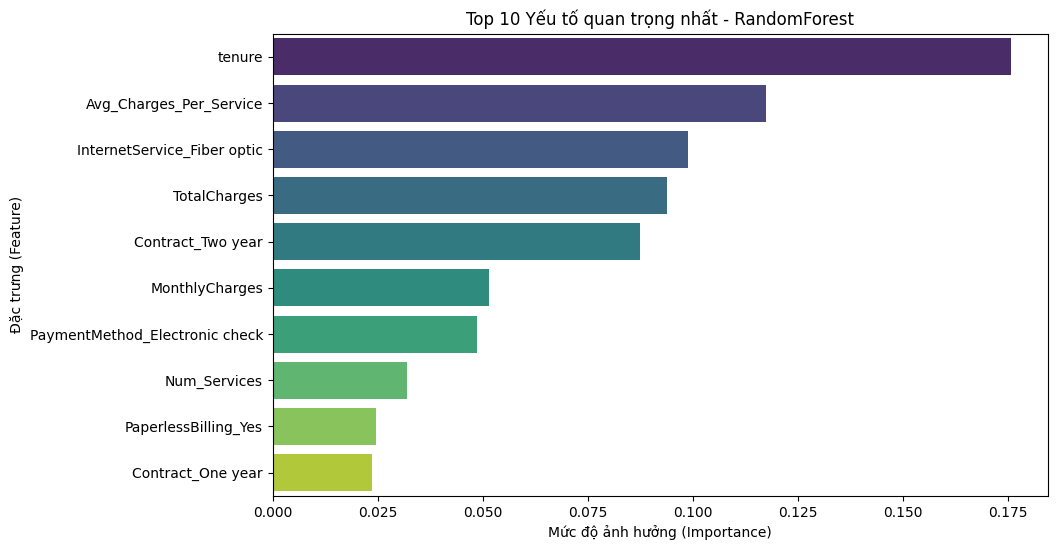

   - Lưu biểu đồ Feature Importance tại: models_and_results\RandomForest_feature_importance.png


In [7]:
def visualize_feature_importance(best_model):
    """
    Vẽ và lưu biểu đồ tầm quan trọng của các đặc trưng (Feature Importance).
    Random Forest xác định importance dựa trên giảm độ impurity (Gini/Entropy) trên toàn bộ cây.
    
    Args:
        best_model (Pipeline): Mô hình đã huấn luyện (Pipeline với RandomForest)
    """
    print("\n4. VISUALIZE FEATURE IMPORTANCE")
    
    # Trích xuất feature importance từ Random Forest model
    importances = best_model.named_steps['model'].feature_importances_
    feature_names = X_train.columns
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    
    # Sắp xếp theo importance giảm dần, chọn top 10
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10)
    
    # Vẽ barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
    plt.title(f'Top 10 Yếu tố quan trọng nhất - {model_name}')
    plt.xlabel('Mức độ ảnh hưởng (Importance)')
    plt.ylabel('Đặc trưng (Feature)')
    
    # Lưu biểu đồ
    img_path = os.path.join(output_folder, f'{model_name}_feature_importance.png')
    plt.savefig(img_path, dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"   - Lưu biểu đồ Feature Importance tại: {img_path}")

visualize_feature_importance(best_model)

In [8]:
def save_model(best_model):
    """
    Lưu mô hình đã huấn luyện để sử dụng trong bước Prediction sau này.
    
    Args:
        best_model (Pipeline): Mô hình đã huấn luyện (Pipeline với SMOTE + RandomForest)
    """
    print("\n5. SAVE MODEL")
    
    # Lưu mô hình dưới dạng pickle file
    model_path = os.path.join(output_folder, f'{model_name}.pkl')
    joblib.dump(best_model, model_path)
    
    print(f"   - Lưu mô hình tại: {model_path}")
    print(f"   → Sẽ dùng cho predict.ipynb")
    print("\n--- HOÀN THÀNH ---")

save_model(best_model)


5. SAVE MODEL
   - Lưu mô hình tại: models_and_results\RandomForest.pkl
   → Sẽ dùng cho predict.ipynb

--- HOÀN THÀNH ---
